In [1]:
git_dir = '/mnt/c/Users/ArcaroLab/Desktop/git_repos/dhcp'

import os
import sys
#add git_dir to path
sys.path.append(git_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params

from sklearn.manifold import MDS

In [12]:
sub_list = pd.read_csv(f'{params.out_dir}/participants.csv')
sub_list = sub_list.head(30)
atlas = 'wang'

data_dir = f'{params.derivatives_dir}/fc_matrix'

#load atlast name and roi labels
atlas_name, roi_labels = params.load_roi_info(atlas)

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
roi_labels['network'] = ['EVC']*7 + ['ventral']*4 + ['lateral']*6 + ['dorsal']*8

networks = ['EVC', 'ventral', 'lateral', 'dorsal']
network_colors = ['k', 'r', 'b', 'g']

#expand roi labels to include hemis
all_labels = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_labels.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




In [19]:
n =0

for sub in sub_list['participant_id']:

    #check if file exists
    if not os.path.exists(f'{data_dir}/{sub}_{atlas}_fc.npy'):
        print(f'{sub} does not exist')
        continue
    #load fc matrix
    fc_mat = np.load(f'{data_dir}/{sub}_{atlas}_fc.npy')
    fc_mat = np.round(fc_mat, 4)

   

    if n == 0:
        mean_fc = fc_mat
    else:
        mean_fc = mean_fc + fc_mat

    n = n + 1

#divide by number of subjects
mean_fc = mean_fc / len(sub_list)

        

In [21]:
#save mean_fc as csv 
#convert to dataframe
mean_fc_df = pd.DataFrame(mean_fc)
mean_fc_df.to_csv('mean_fc.csv', index=False, header=False)


### Visualize correlation matrix

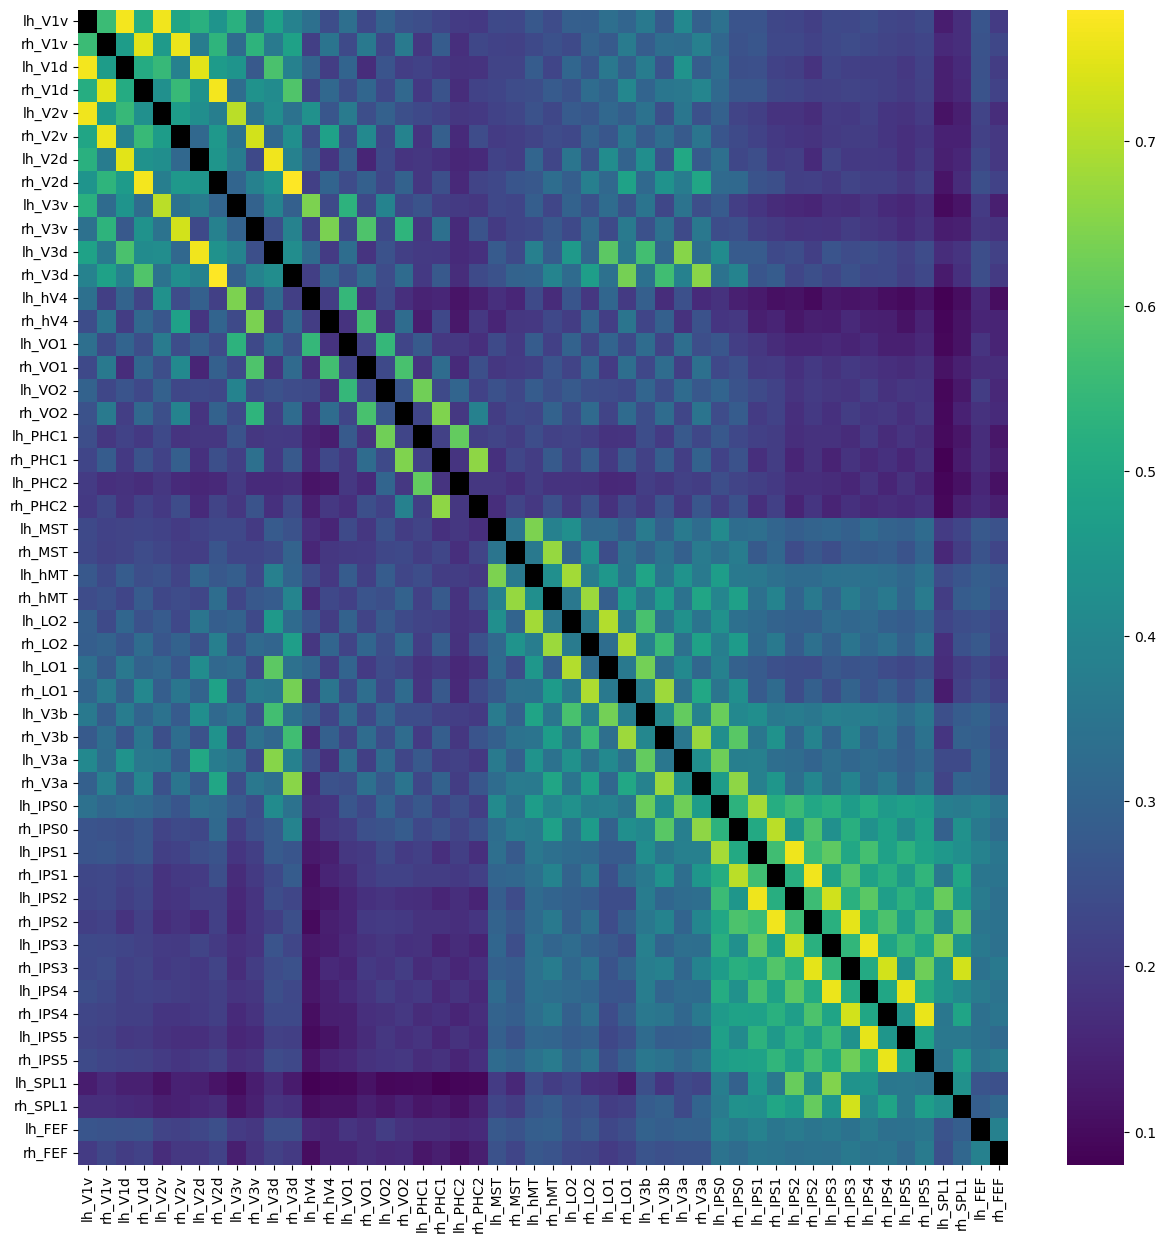

In [17]:
#make diagonal to nans
mean_fc = np.array(mean_fc)
np.fill_diagonal(mean_fc, np.nan)


sns.heatmap(mean_fc, cmap= 'viridis')
#make bigger 
plt.gcf().set_size_inches(15,15)

#add labels from all_labels
plt.xticks(np.arange(0.5, len(all_labels), 1), all_labels, rotation = 90);
plt.yticks(np.arange(0.5, len(all_labels), 1), all_labels, rotation = 0);
#make background black
ax = plt.gca()
ax.set_facecolor('black')

plt.show()



/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/treeshrew1/anaconda3/envs/fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, 'MDS dimension 2')

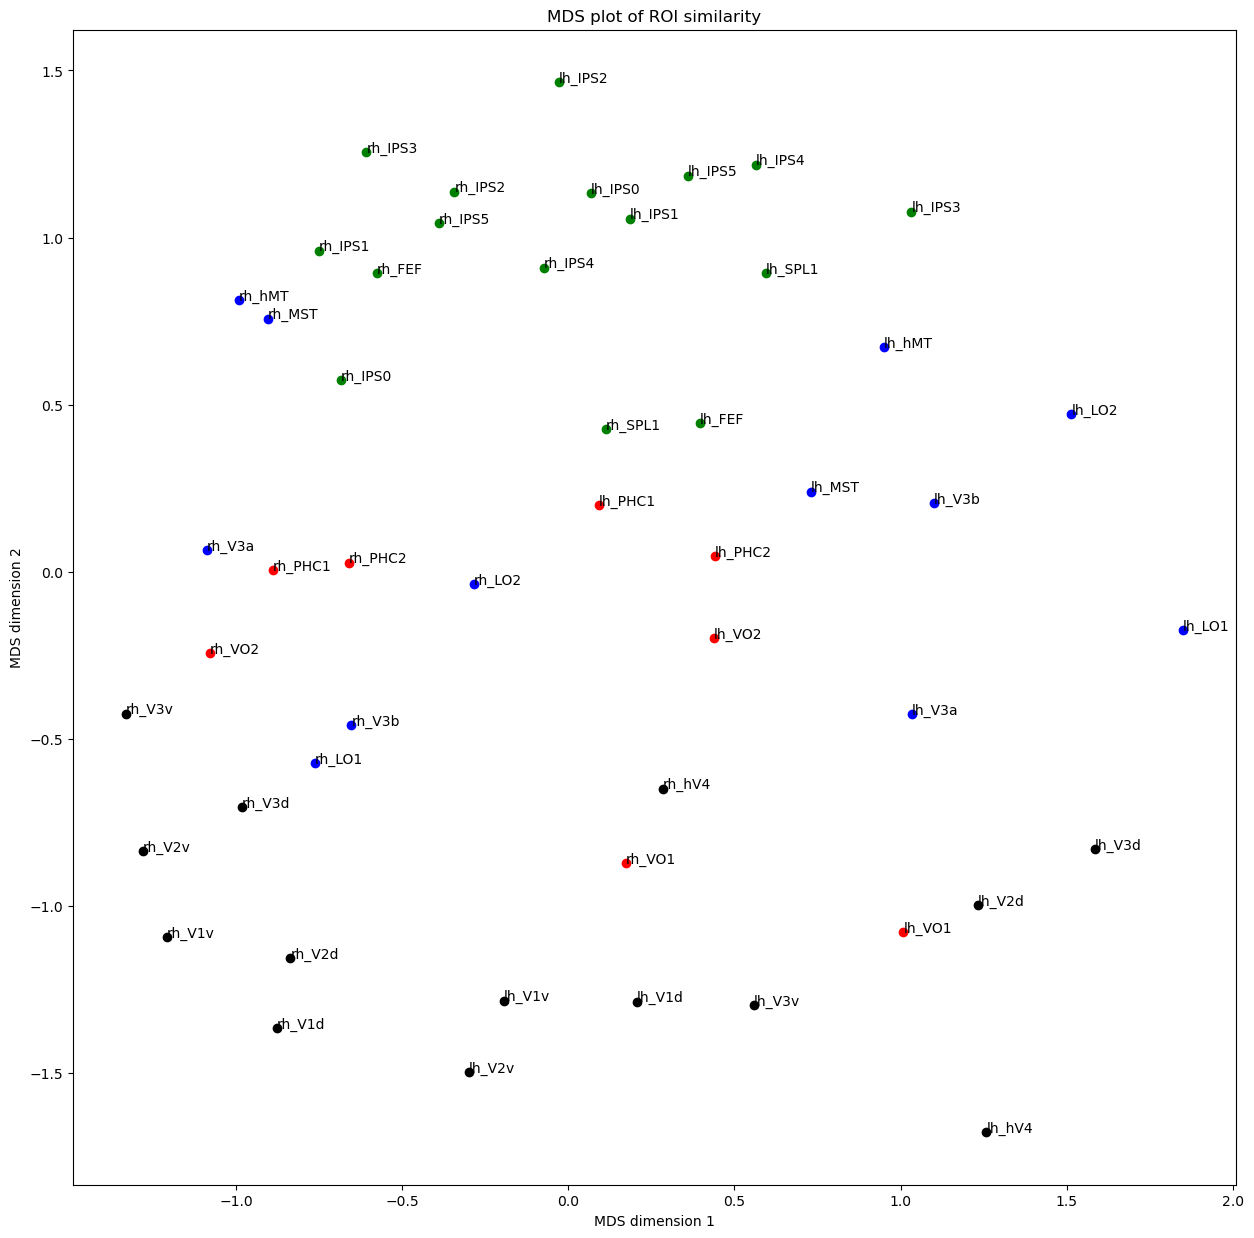

In [29]:
#plot mds results
#plt.scatter(mds_results[:,0], mds_results[:,1])

#run MDS on fc matrix
mds = MDS(n_components = 2)
mds_results = mds.fit(fc_mat).embedding_

for i, net_id in enumerate(all_networks):
    plt.scatter(mds_results[i,0], mds_results[i,1], c = network_colors[networks.index(net_id)], label = net_id)

#add labels
for i, label in enumerate(all_labels):
    plt.annotate(label, (mds_results[i,0], mds_results[i,1]) )

#color code points by network and network_color
for i, net in enumerate(networks):
    plt.scatter(mds_results[networks==net,0], mds_results[networks==net,1], c = network_colors[i], label = net)

#add lines between points

#make plot larger
plt.rcParams['figure.figsize'] = [15, 15]
plt.title('MDS plot of ROI similarity')
plt.xlabel('MDS dimension 1')
plt.ylabel('MDS dimension 2')



In [27]:
#save all labels
#convert all labels to dataframe
label_df = pd.DataFrame(np.asanyarray(all_labels))
#save
label_df.to_csv('labels.csv', index=False, header=False)